# 1. Importing the libraries

In [ ]:
#import the required libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns #statical data visualisation

#machine learning and statistical modeling
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib #function as pipeline
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# 2. Load the dataset and add headers

In [ ]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('ratings_Electronics.csv',names=columns)

In [ ]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR5,132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,439886341,1.0,1334707200


#### Dropping the timestamp column

In [ ]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [ ]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     51 non-null     object 
 1   productId  51 non-null     int64  
 2   ratings    51 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  51
Number of columns:  3


In [ ]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId      int64
ratings      float64
dtype: object

In [ ]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

In [ ]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     51 non-null     object 
 1   productId  51 non-null     int64  
 2   ratings    51 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    51.000000
mean      3.450980
std       1.390162
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: ratings, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

# Handling Missing values

In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


* There are no missing records in the dataset.

## Ratings

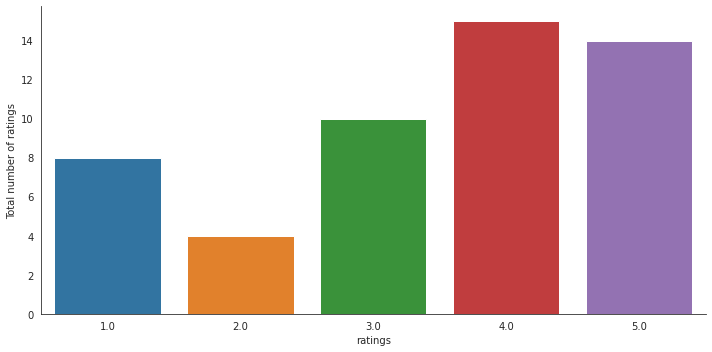

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

* We can see that more number of users have given the rating of 4.

## Users and products

In [ ]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  13
Number of unique product in Raw data =  11


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [ ]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A5SGA5DGS6SG67    7
AHK784384YFB7D    7
AMR3HCGXJXGSJS    6
APDHILLON38282    6
A2NWSAGRHCP8N5    4
AKM1MP6P0OYPR5    4
A1GI0U4ZRJA8WN    3
A2CX7LUOHB2NDG    3
A6DHS7DDGD7BD8    3
A83487GFU34844    3
dtype: int64


In [ ]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=5].index)]
print('Number of users who have rated 5 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 5 or more items = 26
Number of unique users in the final data =  4
Number of unique products in the final data =  4


* electronics_df1_final has the users who have rated 5 or more items.

## ratings analysis in final dataset

In [ ]:
#constructing the pivot table

final_ratings_matrix = electronics_df1_final.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873
userId,,,,,,,,,
A5SGA5DGS6SG67,3.0,1.0,0.0,5.0,2.0,4.0,3.0,1.0,0.0
AHK784384YFB7D,1.0,5.0,5.0,3.0,4.0,5.0,0.0,3.0,0.0
AMR3HCGXJXGSJS,4.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,1.0
APDHILLON38282,5.0,0.0,0.0,4.5,0.0,3.0,5.0,1.0,0.0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (4, 9)


* We can see that there are 9 products and 4 users.

In [ ]:
#Calculating the density of the rating matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given num of ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible num of ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given num of ratings =  24
possible num of ratings =  36
density: 66.67%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [ ]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
37,AHK784384YFB7D,383287382,3.0
38,APDHILLON38282,383287382,5.0
32,APDHILLON38282,3436373626,1.0
7,A5SGA5DGS6SG67,439886341,2.0
23,APDHILLON38282,2763838373,5.0


In [ ]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (18, 3)
Shape of testing data:  (8, 3)


# 5. Building Popularity Recommender model

In [ ]:
#Count of user_id for each unique product as recommendation score
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,132793040,3
1,263746263,3
2,363452737,1
3,383287382,3
4,439886341,2
5,848747388,3
6,2763838373,1
7,3436373626,2


In [ ]:
#Sort the products on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

#Generate a recommendation rank based upon score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

#Get the top 5 recommendations
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productId,score,rank
0,132793040,3,1.0
1,263746263,3,2.0
3,383287382,3,3.0
5,848747388,3,4.0
4,439886341,2,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Add user_id column for which the recommendations are being generated
    user_recommendations['userId'] = user_id

    #Bring user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [ ]:
find_recom = [4,6,7]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

The list of recommendations for the userId: 4

   userId  productId  score  rank
0       4  132793040      3   1.0
1       4  263746263      3   2.0
3       4  383287382      3   3.0
5       4  848747388      3   4.0
4       4  439886341      2   5.0


The list of recommendations for the userId: 6

   userId  productId  score  rank
0       6  132793040      3   1.0
1       6  263746263      3   2.0
3       6  383287382      3   3.0
5       6  848747388      3   4.0
4       6  439886341      2   5.0


The list of recommendations for the userId: 7

   userId  productId  score  rank
0       7  132793040      3   1.0
1       7  263746263      3   2.0
3       7  383287382      3   3.0
5       7  848747388      3   4.0
4       7  439886341      2   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [ ]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,37,AHK784384YFB7D,383287382,3.0
1,38,APDHILLON38282,383287382,5.0
2,32,APDHILLON38282,3436373626,1.0
3,7,A5SGA5DGS6SG67,439886341,2.0
4,23,APDHILLON38282,2763838373,5.0


## User Based Collaborative Filtering model

In [ ]:
# Matrix with row per 'user' and column per 'item'
pivot_df = electronics_df_CF.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873
userId,,,,,,,,,
A5SGA5DGS6SG67,3.0,1.0,0.0,5.0,2.0,4.0,3.0,1.0,0.0
AHK784384YFB7D,1.0,5.0,5.0,3.0,4.0,5.0,0.0,3.0,0.0
AMR3HCGXJXGSJS,4.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,1.0
APDHILLON38282,5.0,0.0,0.0,4.5,0.0,3.0,5.0,1.0,0.0


In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (4, 9)


In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873,user_index
userId,,,,,,,,,,
A5SGA5DGS6SG67,3.0,1.0,0.0,5.0,2.0,4.0,3.0,1.0,0.0,0
AHK784384YFB7D,1.0,5.0,5.0,3.0,4.0,5.0,0.0,3.0,0.0,1
AMR3HCGXJXGSJS,4.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,1.0,2
APDHILLON38282,5.0,0.0,0.0,4.5,0.0,3.0,5.0,1.0,0.0,3


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873
user_index,,,,,,,,,
0,3.0,1.0,0.0,5.0,2.0,4.0,3.0,1.0,0.0
1,1.0,5.0,5.0,3.0,4.0,5.0,0.0,3.0,0.0
2,4.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,1.0
3,5.0,0.0,0.0,4.5,0.0,3.0,5.0,1.0,0.0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [ ]:
pivot_df.shape

(4, 9)

In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 3)

In [ ]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.27934616  0.29055271  0.49903937]
 [-0.33358458 -0.70538787  0.58075691]
 [ 0.89636117 -0.11157972  0.41800448]
 [-0.08499238  0.6368336   0.48882857]]


In [ ]:
print('Sigma: \n',sigma)

Sigma: 
 [ 5.24210685  7.92916982 14.96100892]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [ ]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 5.24210685  0.          0.        ]
 [ 0.          7.92916982  0.        ]
 [ 0.          0.         14.96100892]]


In [ ]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 0.37940083 -0.0294818  -0.31817797 -0.53031164 -0.3611202   0.27498889
  -0.24093373  0.42356107  0.17099254]
 [ 0.36625769 -0.43630622 -0.44480563  0.27775306 -0.28255746 -0.12764594
   0.51150704 -0.20621278 -0.01407206]
 [ 0.41401191  0.28332534  0.19409016  0.43026484  0.22198412  0.56523261
   0.26343551  0.29424196  0.02793959]]


In [ ]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873
0,3.379287,1.153336,0.890269,4.628882,1.535206,3.523342,3.498090,1.101521,-0.074214
1,0.885246,4.953608,4.730647,3.112283,4.140625,5.144214,-0.150699,2.969285,0.022454
2,4.047831,2.019337,0.112269,-0.046800,-0.058613,4.939890,0.062812,4.012802,0.990641
3,4.708225,-0.117957,-0.684860,4.785491,0.357554,3.366680,4.616833,0.921903,0.057091


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0
    user_idx = userID-1
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
439886341                   0.0          0.357554
3873783873                  0.0          0.057091
263746263                   0.0         -0.117957
363452737                   0.0         -0.684860


In [ ]:
userID = 3
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 3):

                   user_ratings  user_predictions
Recommended Items                                
363452737                   0.0          0.112269
2763838373                  0.0          0.062812
383287382                   0.0         -0.046800
439886341                   0.0         -0.058613


In [ ]:
userID = 2
num_recommendations = 6
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
3873783873                  0.0          0.022454
2763838373                  0.0         -0.150699


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model

In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873
userId,,,,,,,,,
A5SGA5DGS6SG67,3.0,1.0,0.0,5.0,2.0,4.0,3.0,1.0,0.0
AHK784384YFB7D,1.0,5.0,5.0,3.0,4.0,5.0,0.0,3.0,0.0
AMR3HCGXJXGSJS,4.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,1.0
APDHILLON38282,5.0,0.0,0.0,4.5,0.0,3.0,5.0,1.0,0.0


In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
132793040    3.250
263746263    2.000
363452737    1.250
383287382    3.125
439886341    1.500
dtype: float64

In [ ]:
# Predicted ratings
preds_df.head()

productId,132793040,263746263,363452737,383287382,439886341,848747388,2763838373,3436373626,3873783873
0,3.379287,1.153336,0.890269,4.628882,1.535206,3.523342,3.498090,1.101521,-0.074214
1,0.885246,4.953608,4.730647,3.112283,4.140625,5.144214,-0.150699,2.969285,0.022454
2,4.047831,2.019337,0.112269,-0.046800,-0.058613,4.939890,0.062812,4.012802,0.990641
3,4.708225,-0.117957,-0.684860,4.785491,0.357554,3.366680,4.616833,0.921903,0.057091


In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
132793040    3.255147
263746263    2.002081
363452737    1.262081
383287382    3.119964
439886341    1.493693
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(9, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
132793040,3.250,3.255147,0
263746263,2.000,2.002081,1
363452737,1.250,1.262081,2
383287382,3.125,3.119964,3
439886341,1.500,1.493693,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00608 



# 8. Getting top - K ( K = 5) recommendations.

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
439886341                   0.0          0.357554
3873783873                  0.0          0.057091
263746263                   0.0         -0.117957
363452737                   0.0         -0.684860


# Summary


* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequency counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.